In [28]:
# Parameters
N_NODES = 200  # number of nodes
ER_P = 0.02    # ER: edge probability
BA_M = 3       # BA: edges to attach per new node
WS_K = 4       # WS: number of neighbors each node connects to
WS_BETA = 0.1  # WS: rewiring probability
N_RUNS = 500     # how many runs to average per curve

In [21]:
# Import modules
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# make the plots look nice
plt.rcParams["figure.figsize"] = (6, 4)

Nodes: 100, Edges: 224


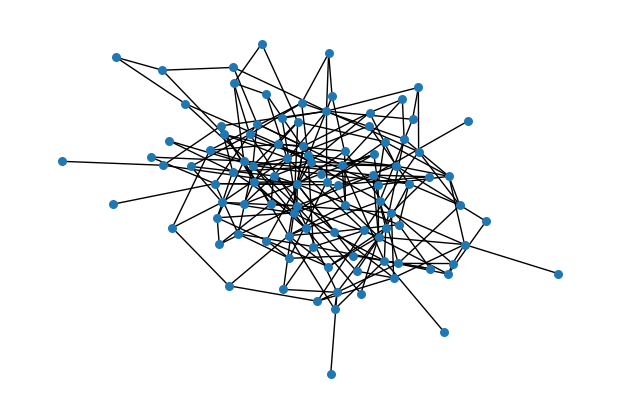

In [22]:
# Generate a sample graph
# Erdos-Renyi graph: n=100 nodes, edge probability=0.05
G = nx.erdos_renyi_graph(100, 0.05, seed=42)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
nx.draw(G, node_size=30, with_labels=False)
plt.show()

In [23]:
# Define functions
def largest_component_size(G):
    """Returns the size of the largest connected component as a fraction of nodes"""
    if G.number_of_nodes() == 0:
        return 0
    return len(max(nx.connected_components(G), key=len)) / G.number_of_nodes()

def simulate_removal(G, strategy="random"):
    """Removes nodes one by one and records giant component size
    strategy: "random" or "degree" """
    # copy graph to preserve original
    H = G.copy()
    sizes = [largest_component_size(H)]

    if strategy == "random":
        nodes = list(H.nodes())
        np.random.shuffle(nodes)
    elif strategy == "degree":
        # sorts nodes by degree decreasing
        nodes = sorted(H.degree, key=lambda x: x[1], reverse=True)
        nodes = [n for n, d in nodes]
    else:
        raise ValueError("Unknown strategy")

    for node in nodes:
        H.remove_node(node)
        sizes.append(largest_component_size(H))

    return sizes

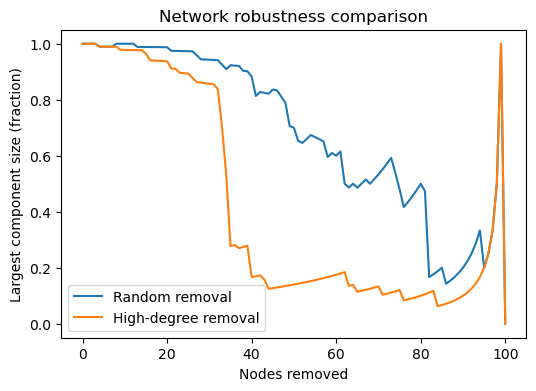

In [24]:
# Test random vs degree-based removal
random_curve = simulate_removal(G, strategy="random")
degree_curve = simulate_removal(G, strategy="degree")

plt.plot(random_curve, label="Random removal")
plt.plot(degree_curve, label="High-degree removal")
plt.xlabel("Nodes removed")
plt.ylabel("Largest component size (fraction)")
plt.legend()
plt.title("Network robustness comparison")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:31<00:00, 47.60it/s]


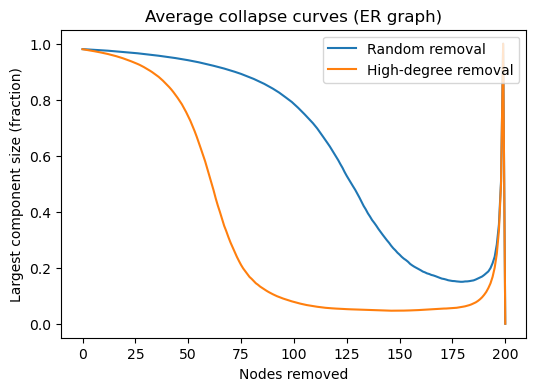

In [25]:
# Repeat experiments for averages
def average_curve(G_generator, n_runs=10, strategy="random"):
    """Runs multiple simulations and averages the results"""
    curves = []
    for _ in tqdm(range(n_runs)):
        G = G_generator()
        sizes = simulate_removal(G, strategy=strategy)
        curves.append(sizes)
    # pad shorter curves with zeros
    max_len = max(len(c) for c in curves)
    curves = [c + [0]*(max_len - len(c)) for c in curves]
    return np.mean(curves, axis=0)

# Example: compare random vs degree removal on ER graphs
n = 200
p = 0.02
generator = lambda: nx.erdos_renyi_graph(n, p)

random_avg = average_curve(generator, strategy="random", n_runs=1500)
degree_avg = average_curve(generator, strategy="degree", n_runs=1500)

plt.plot(random_avg, label="Random removal")
plt.plot(degree_avg, label="High-degree removal")
plt.xlabel("Nodes removed")
plt.ylabel("Largest component size (fraction)")
plt.legend()
plt.title("Average collapse curves (ER graph)")
plt.show()

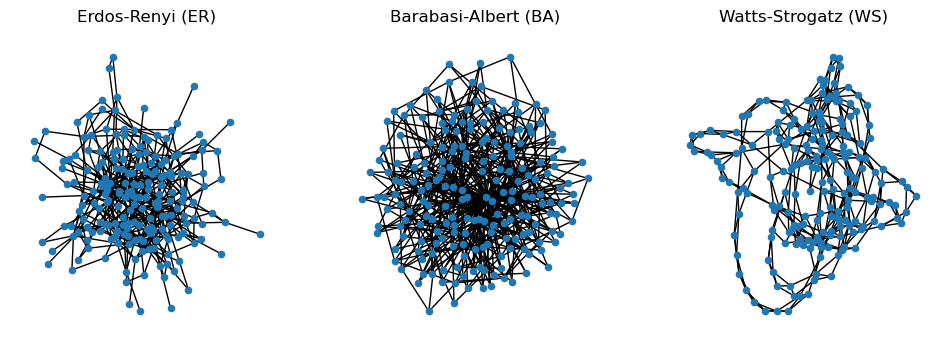

In [26]:
# Add graph generaters with new graph types

def er_graph():
    return nx.erdos_renyi_graph(N_NODES, ER_P)

def ba_graph():
    return nx.barabasi_albert_graph(N_NODES, BA_M)

def ws_graph():
    return nx.watts_strogatz_graph(N_NODES, WS_K, WS_BETA)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

nx.draw(er_graph(), ax=axs[0], node_size=20, with_labels=False)
axs[0].set_title("Erdos-Renyi (ER)")

nx.draw(ba_graph(), ax=axs[1], node_size=20, with_labels=False)
axs[1].set_title("Barabasi-Albert (BA)")

nx.draw(ws_graph(), ax=axs[2], node_size=20, with_labels=False)
axs[2].set_title("Watts-Strogatz (WS)")

plt.show()

In [29]:
# Compare network robustness between models
models = {
    "ER": er_graph,
    "BA": ba_graph,
    "WS": ws_graph,
}

strategies = ["random", "degree"]

results = {}

for model_name, gen in models.items():
    for strat in strategies:
        avg_curve = average_curve(gen, n_runs=N_RUNS, strategy=strat)
        results[(model_name, strat)] = avg_curve

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 61.82it/s]


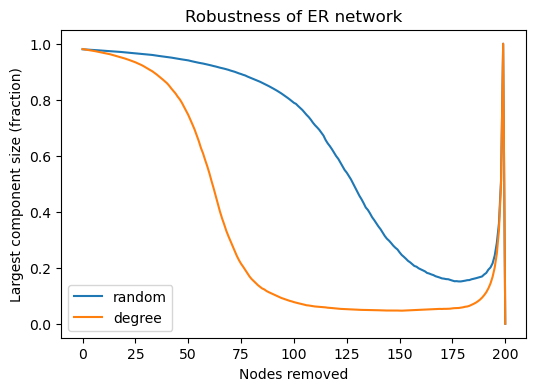

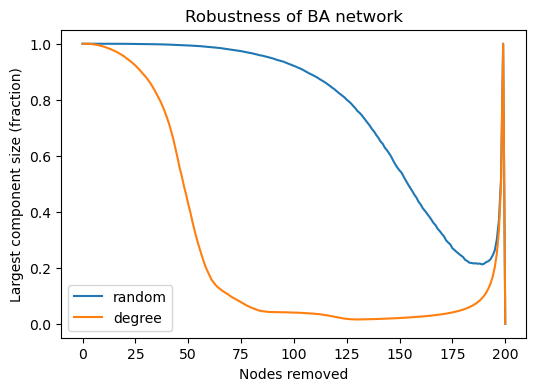

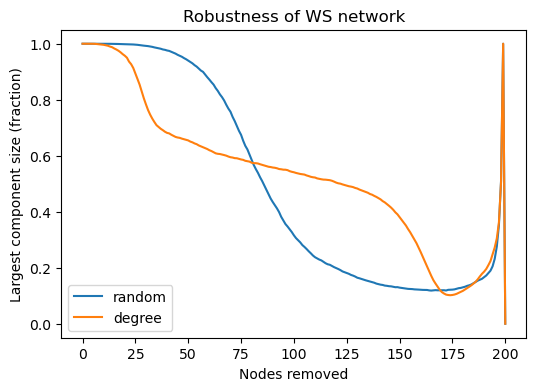

In [30]:
# Compare plots by model
for model_name in models:
    plt.figure(figsize=(6, 4))
    for strat in strategies:
        curve = results[(model_name, strat)]
        plt.plot(curve, label=strat)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"Robustness of {model_name} network")
    plt.legend()
    plt.show()

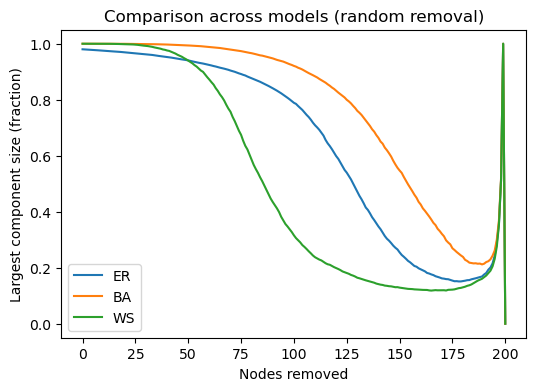

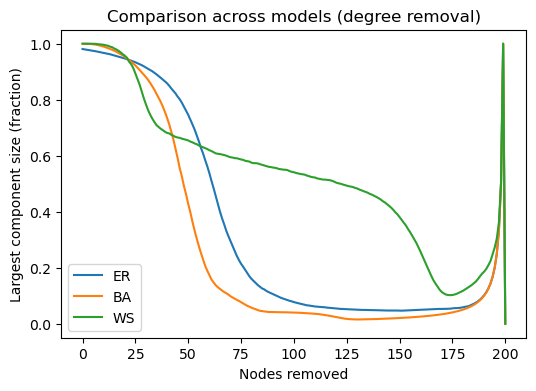

In [31]:
# Compare plots by strategy
for strat in strategies:
    plt.figure(figsize=(6, 4))
    for model_name in models:
        curve = results[(model_name, strat)]
        plt.plot(curve, label=model_name)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"Comparison across models ({strat} removal)")
    plt.legend()
    plt.show()

In [32]:
from sklearn.metrics import auc

# Function to compute robustness score (AUC)
def robustness_score(curve):
    """ curve: list of largest component fractions as nodes are removed. returns
    normalized area under the curve (0-1) """
    x = np.linspace(0, 1, len(curve))  # fraction of nodes removed
    score = auc(x, curve) / 1.0  # normalized for a max of 1
    return score

In [33]:
import pandas as pd

# Compute robustness scores for all models and strategies
scores = {}
for (model_name, strat), curve in results.items():
    scores[(model_name, strat)] = robustness_score(curve)

# show nicely
pd.DataFrame(scores, index=["Robustness Score"]).T

Robustness Score
ER random          0.646438
   degree          0.342395
BA random          0.770734
   degree          0.272290
WS random          0.500729
   degree          0.535811

In [34]:
import os

# Create results directory
os.makedirs("results", exist_ok=True)

In [35]:
# Save strategy and model comparisons
for model_name in models:
    plt.figure(figsize=(6, 4))
    for strat in strategies:
        curve = results[(model_name, strat)]
        plt.plot(curve, label=strat)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"{model_name} robustness (N={N_NODES})")
    plt.legend()
    filename = f"results/{model_name}_N{N_NODES}_robustness.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

for strat in strategies:
    plt.figure(figsize=(6, 4))
    for model_name in models:
        curve = results[(model_name, strat)]
        plt.plot(curve, label=model_name)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"Comparison across models ({strat} removal)")
    plt.legend()
    filename = f"results/comparison_{strat}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

In [36]:
# Save robustness scores
df_scores = pd.DataFrame(scores, index=["Robustness Score"]).T
df_scores.to_csv("results/robustness_scores.csv")